# Programming Exercise 8: Anomaly Detection and Recommender Systems
> In this exercise, you will implement the anomaly detection algorithm and apply it to detect failing servers on a network. In the second part, you will use collaborative filtering to build a recommender system for movies.

## 1. Anomaly Detection
> In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server.

In [5]:
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
mat = scipy.io.loadmat('data/ex8data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

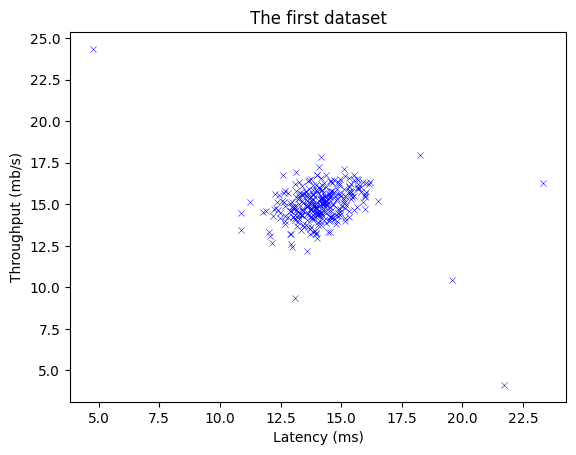

In [8]:
# Scatter plot of the first dataset with markers and labels.
ax = sns.scatterplot(x=mat['X'][:,0], y=mat['X'][:,1], marker='x', color='b', s=20)
ax.set(xlabel='Latency (ms)', ylabel='Throughput (mb/s)', title='The first dataset');


### 1.1 Gaussian Distribution

> To perform anomaly detection, you will first need to fit a model to the data’s distribution.

The Gaussian distribution is given by: 

$$p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}} = \frac{1}{\sqrt{(2\pi^k)det\Sigma}}e^{-\frac{1}{2}(x-\mu)^T \Sigma^{-1} (x-\mu)}$$

where $\mu$ is the mean and $\sigma^2$ controls the variance; $\Sigma$ is the covariance matrix and $k$ is the dimension of the space where $x$ takes values.

### 1.2 Estimating Parameters for a Gaussian

Mean: $\mu_i = \frac{1}{m}\sum_{j=1}^m x_i^{(j)}$

Variance: $\sigma_i^2 = \frac{1}{m}\sum_{j=1}^m(x_i^{(j)}-\mu_i)^2$

In [9]:
def estimate_gaussian(X):
    mean = np.mean(X, axis=0)
    var = np.var(X, axis=0)
    return mean, var

In [10]:
from scipy.stats import multivariate_normal
def multivariate_gaussian(X, mu, sigma):
    p = multivariate_normal.pdf(X, mu, np.diag(sigma))
    return p

In [11]:
mu, sigma2 = estimate_gaussian(mat['X'])
mu, sigma2

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

In [12]:
p = multivariate_gaussian(mat['X'], mu, sigma2)

In [15]:
def visualize_fit(X, mu, sigma2):
    x, y = np.mgrid[0:35.5:0.5, 0:35.5:0.5]
    pos = np.dstack((x, y))
    z = multivariate_gaussian(pos, mu, sigma2)
    z = z.reshape(x.shape)
    ax = sns.scatterplot(x=X[:,0], y=X[:,1], marker='x', color='b', s=20)
    ax.contour(x, y, z, levels=10.0**(np.arange(-20,0,3)))
    ax.set(xlabel='Latency (ms)', ylabel='Throughput (mb/s)', title='Visualizing Gaussian Fit');
    ax.set_xlim(0,30)
    ax.set_ylim(0,30)
    return ax

<Axes: title={'center': 'Visualizing Gaussian Fit'}, xlabel='Latency (ms)', ylabel='Throughput (mb/s)'>

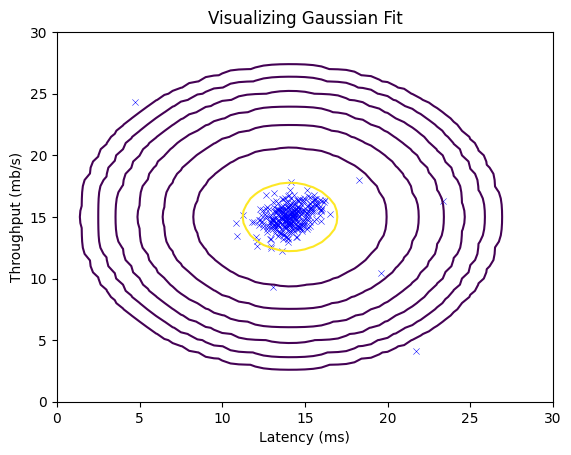

In [16]:
visualize_fit(mat['X'], mu, sigma2)

### 1.3 Selecting the threshold $\epsilon$

The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. In this part of the exercise, you will implement an algorithm to select the threshold $\epsilon$ using the $F1 score$ on a cross validation set.

$$F_1 = \frac{2 \cdot prec \cdot rec}{prec + rec}$$

$$prec = \frac{tp}{tp+fp}$$

$$rec = \frac{tp}{tp+fn}$$

* tp: true positive; label says it's true and our algorithm too
* fp: false positive; label says it's not true and our algorithm says it's true
* fn: false negative; label says it's true and our algorithm says it's not true

In [17]:
# Function to select the threshold value for anomaly detection
def select_threshold(yval, pval):
    # Initialize variables to store the best F1 score and corresponding epsilon
    best_f1 = 0
    best_epsilon = 0
    
    # Calculate the step size for the range of epsilon values
    step = (np.max(pval) - np.min(pval)) / 1000
    
    # Iterate over a range of epsilon values
    for epsilon in np.arange(np.min(pval), np.max(pval), step):
        # Predict anomalies based on the current epsilon value
        y_pred = pval < epsilon
        
        # Calculate true positives (tp), false positives (fp), and false negatives (fn)
        tp = np.sum(np.logical_and(yval == 1, y_pred == 1))
        fp = np.sum(np.logical_and(yval == 0, y_pred == 1))
        fn = np.sum(np.logical_and(yval == 1, y_pred == 0))
        
        # Calculate precision and recall
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        
        # Calculate F1 score
        f1 = (2 * precision * recall) / (precision + recall)
        
        # Update the best F1 score and corresponding epsilon if a better F1 score is found
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    # Return the best epsilon value and the corresponding F1 score
    return best_epsilon, best_f1


In [18]:
pval = multivariate_gaussian(mat['Xval'], mu, sigma2)

In [19]:
epsilon, f1 = select_threshold(mat['yval'].ravel(), pval)

/tmp/ipykernel_48541/2090707397.py:21: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [20]:
print('Best epsilon found using cross-validation:', epsilon)
print('Best F1 on Cross Validation Set:', f1)
print('   (you should see a value epsilon of about 8.99e-05)')
print('   (you should see a Best F1 value of  0.875000)')

Best epsilon found using cross-validation: 8.990852779269493e-05
Best F1 on Cross Validation Set: 0.8750000000000001
   (you should see a value epsilon of about 8.99e-05)
   (you should see a Best F1 value of  0.875000)


In [21]:
outliers = np.argwhere(p < epsilon)
outliers = outliers.T[0]

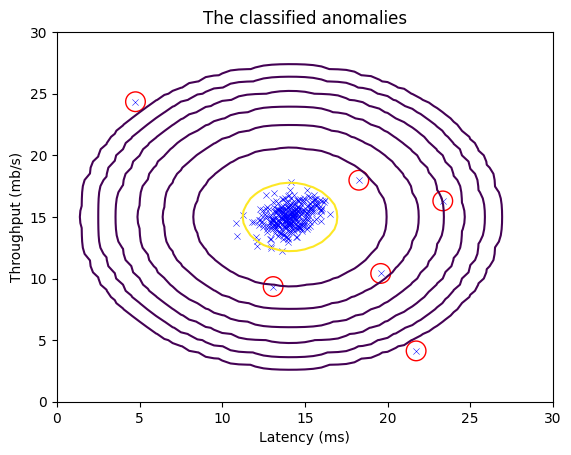

In [22]:
ax = visualize_fit(mat['X'], mu, sigma2)
ax.scatter(x=mat['X'][outliers,0], y=mat['X'][outliers,1], color='r', facecolors='none', s=200)
ax.set(title='The classified anomalies');

### 1.4 High Dimensional Dataset

In [23]:
mat = scipy.io.loadmat('data/ex8data2.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [24]:
# Estimate parameters for the Gaussian distribution
mu, sigma2 = estimate_gaussian(mat['X'])

# Calculate the probability density of the training set and validation set
p = multivariate_gaussian(mat['X'], mu, sigma2)
pval = multivariate_gaussian(mat['Xval'], mu, sigma2)

# Select the threshold value for anomaly detection based on the validation set
epsilon, f1 = select_threshold(mat['yval'].ravel(), pval)


/tmp/ipykernel_48541/2090707397.py:21: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


In [25]:
print('Best epsilon found using cross-validation:', epsilon)
print('Best F1 on Cross Validation Set:', f1)
print('   (you should see a value epsilon of about 1.38e-18)')
print('   (you should see a Best F1 value of 0.615385)')
print('# Outliers found: ', sum(p < epsilon))

Best epsilon found using cross-validation: 1.3772288907613604e-18
Best F1 on Cross Validation Set: 0.6153846153846154
   (you should see a value epsilon of about 1.38e-18)
   (you should see a Best F1 value of 0.615385)
# Outliers found:  117


## 2. Recommender Systems

> In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings. This dataset consists of ratings on a scale of $1$ to $5$. The dataset has $n_u = 943$ users, and $n_m = 1682$ movies. 

### 2.1 Movie Ratings Dataset

* Matrix $Y$ (num_movies x num_users): ratings $y^{(i,j)}$ (from 1 to 5)
* Matrix $R$: binary where $R(i,j)=1$ if user $j$ gave a rating to movie $i$, and $R(i,j)=0$ otherwise.
* Matrix $X$: each row corresponds to the feature vector $x^{(i)}$ for the i-th movie.
* Matrix $Theta$: each row corresponds to one parameter vector $\theta^{(j)}$ for the j-th user.

In [26]:
mat = scipy.io.loadmat('data/ex8_movies.mat')
Y = mat['Y']
R = mat['R']

In [27]:
mat2 = scipy.io.loadmat('data/ex8_movieParams.mat')
X = mat2['X']
Theta = mat2['Theta']
num_users = mat2['num_users']
num_movies = mat2['num_movies']
num_features = mat2['num_features']

In [28]:
f'Average rating for movie 1 (Toy Story): {np.mean(Y[0, R[0,:]==1])} / 5'

'Average rating for movie 1 (Toy Story): 3.8783185840707963 / 5'

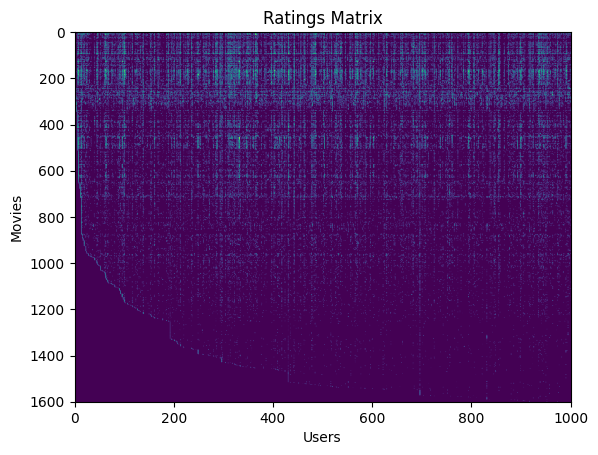

In [29]:
plt.imshow(Y, extent=[0,1000,1600,0], aspect='auto')
plt.title('Ratings Matrix');
plt.xlabel('Users');
plt.ylabel('Movies');

### 2.2 Collaborative Filtering Learning Algorithm

> The collaborative filtering algorithm in the setting of movie recommendations considers a set of n-dimensional parameter vectors $x^{(1)} , ..., x^{(n_m)}$ and $\theta^{(1)},...,\theta^{(n_u)}$, where the model predicts the rating for movie $i$ by user $j$ as $y^{(i,j)} = (\theta^{(j)})^T x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors $x^{(1)},...,x^{(n_m)},\theta^{(1)},...,\theta^{(n_u)}$ that produce the best fit (minimizes the squared error).

#### 2.2.1 Collaborative filtering cost function (without regularization)

$$ J(x^{(1)},...,x^{(n_m)},\theta^{(1)},...,\theta^{(n_u)}) = \frac{1}{2}\sum_{(i,j):r(i,j)=1}((\theta^{(j)})^T x^{(i)}-y^{(i,j)})^2$$

In [30]:
# Define the cost function for collaborative filtering
def cofi_cost_func(params, Y, R, num_users, num_movies, num_features, lambda_r):
    # Reshape the parameters into matrices
    X = np.reshape(params[:num_movies*num_features], newshape=(num_movies, num_features), order='F')
    Theta = np.reshape(params[num_movies*num_features:], newshape=(num_users, num_features), order='F')
    
    # Compute the difference between the predicted and actual ratings
    C = np.subtract(X.dot(Theta.T), Y) ** 2
    
    # Compute the regularized cost function
    J = np.sum(np.sum(R*C)) / 2
    return J


In [31]:
# Reduce the dataset to test with a smaller subset
num_users = 4
num_movies = 5
num_features = 3

# Select a subset of the data
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]


In [32]:
J = cofi_cost_func(np.hstack((X.ravel(order='F'), Theta.ravel(order='F'))),
                   Y, R, num_users, num_movies, num_features, 0)
print('Cost at loaded parameters: ', J)
print('\t(this value should be about 22.22)')

Cost at loaded parameters:  22.224603725685675
	(this value should be about 22.22)


#### 2.2.2 Collaborative filtering gradient (without regularization)

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1}((\theta^{(j)})^T x^{(i)}-y^{(i,j)})\theta_k^{(j)} $$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1}((\theta^{(j)})^T x^{(i)}-y^{(i,j)})x_k^{(i)} $$

In [33]:
def cofi_cost_func(params, Y, R, num_users, num_movies, num_features, lambda_r):
    # Unroll parameters
    X = np.reshape(params[:num_movies*num_features], newshape=(num_movies, num_features), order='F')
    Theta = np.reshape(params[num_movies*num_features:], newshape=(num_users, num_features), order='F')
    
    # Compute cost function
    C = np.subtract(X.dot(Theta.T), Y) ** 2
    J = np.sum(np.sum(R*C)) / 2
    
    # Initialize gradients
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    # Compute gradients
    for i in range(num_movies):
        idx = np.argwhere(R[i,:]==1).T[0]
        X_grad[i,:] = np.subtract(X[i,:].dot(Theta[idx,:].T), Y[i,idx]).dot(Theta[idx,:])
        
    for j in range(num_users):
        idx = np.argwhere(R[:,j]==1).T[0]
        Theta_grad[j,:] = np.subtract(X[idx,:].dot(Theta[j,:].T), Y[idx,j]).T.dot(X[idx,:])
        
    grad = np.hstack((X_grad.ravel(order='F'), Theta_grad.ravel(order='F')))

    return J, grad


##### Checking Gradients (without regularization)

In [34]:
def compute_numerical_gradient(theta, Y, R, num_users, num_movies, num_features, lambda_r):
    e = 0.0001
    num_grad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    for p in range(len(theta)):
        perturb[p] = e
        loss1, _ = cofi_cost_func(theta - perturb, Y, R, num_users, num_movies, num_features, lambda_r)
        loss2, _ = cofi_cost_func(theta + perturb, Y, R, num_users, num_movies, num_features, lambda_r)
        num_grad[p] = (loss2 - loss1) / (2 * e)
        perturb[p] = 0
    return num_grad


In [35]:
def check_cost_function(lambda_r=0):
    # Generate random data for testing
    X_t = np.random.uniform(0, 1, (4, 3))
    Theta_t = np.random.uniform(0, 1, (5, 3))
    
    # Simulate ratings
    Y = X_t.dot(Theta_t.T)
    Y[np.random.uniform(0, 1, Y.shape) > 0.5] = 0
    R = np.zeros(Y.shape)
    R[Y != 0] = 1
    
    # Randomly initialize parameters
    X = np.random.normal(size=X_t.shape)
    Theta = np.random.normal(size=Theta_t.shape)
    num_users = Y.shape[1]
    num_movies = Y.shape[0]
    num_features = Theta_t.shape[1]
    
    # Combine parameters into a single vector
    params = np.hstack((X.ravel(order='F'), Theta.ravel(order='F')))
    
    # Compute cost and gradients using cofi_cost_func
    cost, grad = cofi_cost_func(params, Y, R, num_users, num_movies, num_features, lambda_r)
    
    # Compute numerical gradients using compute_numerical_gradient
    num_grad = compute_numerical_gradient(params, Y, R, num_users, num_movies, num_features, lambda_r)
    
    print('The columns should be very similar...')
    # Compare numerical gradients with gradients from cofi_cost_func
    for i, j in zip(num_grad, grad):
        print(i, j)
    
    # Compute relative difference
    diff = np.linalg.norm(num_grad - grad) / np.linalg.norm(num_grad + grad)
    print('''If your cost function implementation is correct, then the relative difference will 
             be small (less than 1e-9). Relative Difference:''', diff)


In [36]:
check_cost_function()

The columns should be very similar...
2.4218120170527158 2.4218120170501143
0.7306898374404014 0.7306898374383224
-0.36455846321281626 -0.3645584632083586
3.699552871601064 3.699552871598682
-2.2037578141009817 -2.2037578140973793
0.6041618929897297 0.604161892989877
-2.126366692105641 -2.1263666921031543
-0.02560366441528572 -0.02560366441803097
1.1014174040457902 1.1014174040517843
0.78793437063851 0.7879343706410933
-0.2590204881380842 -0.2590204881362018
1.0329999581637495 1.0329999581647087
1.7286550199591133 1.7286550199586153
0.8771699662979415 0.8771699662939825
-0.9324422078016426 -0.9324422078000921
-0.3846524157413711 -0.38465241574346076
-1.1735736742446434 -1.1735736742437535
-1.7711381327911724 -1.7711381327910445
-0.2091362362932614 -0.20913623629192146
1.6831627879421163 1.6831627879408702
0.330592696307086 0.3305926963068408
2.717195564221342 2.7171955642222487
2.889899607443347 2.8898996074454377
-0.10525169597652706 -0.10525169597730685
0.10198054886778607 0.10198054

#### 2.2.3 Regularized cost function

$$ J(x^{(1)},...,x^{(n_m)},\theta^{(1)},...,\theta^{(n_u)}) = \frac{1}{2}\sum_{(i,j):r(i,j)=1}((\theta^{(j)})^T x^{(i)}-y^{(i,j)})^2 + 
\Big(\frac{\lambda}{2}\sum_{j=1}^{n_u}\sum_{k=1}^{n}(\theta_k^{(j)})^2 \Big) + \Big(\frac{\lambda}{2}\sum_{i=1}^{n_m}\sum_{k=1}^{n}(x_k^{(i)})^2 \Big)$$

In [37]:
def cofi_cost_func(params, Y, R, num_users, num_movies, num_features, lambda_r):
    # Unroll parameters into X and Theta matrices
    X = np.reshape(params[:num_movies*num_features], newshape=(num_movies, num_features), order='F')
    Theta = np.reshape(params[num_movies*num_features:], newshape=(num_users, num_features), order='F')
    
    # Compute cost function
    C = np.subtract(X.dot(Theta.T), Y) ** 2
    J = np.sum(np.sum(R*C)) / 2 + ((lambda_r/2)*np.sum(np.sum(Theta**2))) + ((lambda_r/2)*np.sum(np.sum(X**2)))
    
    # Initialize gradients
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    # Compute gradients
    for i in range(num_movies):
        idx = np.argwhere(R[i,:]==1).T[0]
        X_grad[i,:] = np.subtract(X[i,:].dot(Theta[idx,:].T), Y[i,idx]).dot(Theta[idx,:])
        
    for j in range(num_users):
        idx = np.argwhere(R[:,j]==1).T[0]
        Theta_grad[j,:] = np.subtract(X[idx,:].dot(Theta[j,:].T), Y[idx,j]).T.dot(X[idx,:])
        
    # Combine gradients into a single vector
    grad = np.hstack((X_grad.ravel(order='F'), Theta_grad.ravel(order='F')))

    return J, grad


In [38]:
# Compute the cost at loaded parameters
J, _ = cofi_cost_func(np.hstack((X.ravel(order='F'), Theta.ravel(order='F'))),
                      Y, R, num_users, num_movies, num_features, 1.5)
print('Cost at loaded parameters (lambda = 1.5):', J)
print('\t(this value should be about 31.34)')


Cost at loaded parameters (lambda = 1.5): 31.34405624427422
	(this value should be about 31.34)


#### 2.2.4 Regularized gradient

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1}((\theta^{(j)})^T x^{(i)}-y^{(i,j)})\theta_k^{(j)} + \lambda x_k^{(i)}$$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1}((\theta^{(j)})^T x^{(i)}-y^{(i,j)})x_k^{(i)} + \lambda \theta_k^{(j)}$$



In [39]:
def cofi_cost_func(params, Y, R, num_users, num_movies, num_features, lambda_r):
    # Reshape parameters into matrices
    X = np.reshape(params[:num_movies*num_features], newshape=(num_movies, num_features), order='F')
    Theta = np.reshape(params[num_movies*num_features:], newshape=(num_users, num_features), order='F')
    
    # Compute squared error and regularized cost function
    C = np.subtract(X.dot(Theta.T), Y) ** 2
    J = np.sum(np.sum(R*C)) / 2 + ((lambda_r/2)*np.sum(np.sum(Theta**2))) + ((lambda_r/2)*np.sum(np.sum(X**2)))
    
    # Initialize gradient matrices
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    
    # Compute gradients for X
    for i in range(num_movies):
        idx = np.argwhere(R[i,:]==1).T[0]
        X_grad[i,:] = np.subtract(X[i,:].dot(Theta[idx,:].T), Y[i,idx]).dot(Theta[idx,:]) + (lambda_r * X[i,:])
        
    # Compute gradients for Theta
    for j in range(num_users):
        idx = np.argwhere(R[:,j]==1).T[0]
        Theta_grad[j,:] = np.subtract(X[idx,:].dot(Theta[j,:].T), Y[idx,j]).T.dot(X[idx,:]) + (lambda_r * Theta[j,:])
        
    # Concatenate gradients
    grad = np.hstack((X_grad.ravel(order='F'), Theta_grad.ravel(order='F')))

    return J, grad


In [40]:
check_cost_function(1.5)

The columns should be very similar...
-0.41302022619760237 -0.4130202262174525
0.15842465082016588 0.15842465083745882
5.346235181793446 5.346235181807199
1.143455018013384 1.1434550180069283
-0.7614495531882426 -0.7614495531741247
-2.743936663325286 -2.743936663316507
1.3365995235758987 1.3365995235529464
1.8757705986338635 1.8757705986322426
2.5564992147053545 2.5564992147032157
0.12355255186946579 0.1235525518653886
2.0163254194116575 2.01632541941814
-0.6421244759202693 -0.6421244759180367
-1.3315028951410568 -1.3315028951477725
-5.368292077250203 -5.368292077257828
2.219246291144117 2.2192462911365145
-0.870589804247146 -0.8705898042628584
-2.2413070881555086 -2.241307088152353
2.5532952735396464 2.553295273543856
-1.5890379224359208 -1.5890379224456768
0.6836908181107049 0.6836908181050524
0.38668081677073474 0.3866808167817241
-2.4627586996395223 -2.462758699636831
-1.0379454760922613 -1.0379454760918978
-2.8921566641670893 -2.8921566641713823
-0.8719786579725053 -0.871978657972

### 2.3 Learning movie recommendations

In [41]:
with open('data/movie_ids.txt', encoding='latin-1') as f:
    content = f.readlines()
    
# Extract movie names from file content
movie_list = [' '.join(line.split()[1:]) for line in content]


In [42]:
len(movie_list)

1682

In [43]:
movie_list[:5]

['Toy Story (1995)',
 'GoldenEye (1995)',
 'Four Rooms (1995)',
 'Get Shorty (1995)',
 'Copycat (1995)']

In [44]:
my_ratings = np.zeros((1682, 1))
my_ratings[0] = 4
my_ratings[10] = 4
my_ratings[21] = 5
my_ratings[70] = 5
my_ratings[97] = 2
my_ratings[98] = 5
my_ratings[150] = 4
my_ratings[154] = 4
my_ratings[175] = 3
my_ratings[312] = 5

In [45]:
for i,r in enumerate(my_ratings):
    if r>0:
        print('Rated {0} for {1}'.format(int(r[0]), movie_list[i]))

Rated 4 for Toy Story (1995)
Rated 4 for Seven (Se7en) (1995)
Rated 5 for Braveheart (1995)
Rated 5 for Lion King, The (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 5 for Snow White and the Seven Dwarfs (1937)
Rated 4 for Willy Wonka and the Chocolate Factory (1971)
Rated 4 for Dirty Dancing (1987)
Rated 3 for Aliens (1986)
Rated 5 for Titanic (1997)


In [47]:
mat = scipy.io.loadmat('data/ex8_movies.mat')

# Add your ratings to the Y matrix
Y = np.hstack((my_ratings, mat['Y']))

# Update the R matrix to include your ratings
R = np.hstack((my_ratings != 0, mat['R']))


In [48]:
Y.shape

(1682, 944)

#### Training Collaborative Filtering

In [49]:
def normalize_ratings(Y, R):
    # Initialize arrays to store mean and normalized ratings
    Y_mean = np.zeros((Y.shape[0], 1))
    Y_norm = np.zeros(Y.shape)
    
    # Loop over each user's ratings
    for i in range(Y.shape[0]):
        # Find indices where the user has rated movies
        idx = np.argwhere(R[i, :] == 1).T[0]
        
        # Compute mean of the user's ratings
        Y_mean[i] = np.mean(Y[i, idx], axis=0)
        
        # Subtract the mean from the user's ratings and store in Y_norm
        Y_norm[i, idx] = np.subtract(Y[i, idx], Y_mean[i])
    
    return Y_norm, Y_mean


In [50]:
Y_norm, Y_mean = normalize_ratings(Y, R)

In [51]:
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

In [52]:
X = np.random.normal(size=(num_movies, num_features))
Theta = np.random.normal(size=(num_users, num_features))
initial_params = np.hstack((X.ravel(order='F'), Theta.ravel(order='F')))

In [53]:
import scipy.optimize as opt
lambda_r = 10
opt_results = opt.minimize(cofi_cost_func, initial_params, args=(Y, R, num_users, num_movies, num_features, lambda_r),
                           method='L-BFGS-B', jac=True, options={'maxiter':100})
theta = opt_results['x']

In [54]:
X = np.reshape(theta[:num_movies*num_features], newshape=(num_movies, num_features), order='F')
Theta = np.reshape(theta[num_movies*num_features:], newshape=(num_users, num_features), order='F')    

#### Recommendation

In [55]:
p = X.dot(Theta.T)
my_predictions = p[:,0] + Y_mean.T[0]

In [56]:
sort_idxs = np.argsort(my_predictions)[::-1]
print('Top recommendations for you:')
for i in range(10):
    j = sort_idxs[i]
    print('Predicting rating {0} for movie {1}'.format(my_predictions[j], movie_list[j]))

Top recommendations for you:
Predicting rating 8.381281620326083 for movie Schindler's List (1993)
Predicting rating 8.35923784913831 for movie Titanic (1997)
Predicting rating 8.258820161130355 for movie Star Wars (1977)
Predicting rating 8.212880636309606 for movie Shawshank Redemption, The (1994)
Predicting rating 8.046492886497989 for movie Good Will Hunting (1997)
Predicting rating 8.035100650460954 for movie Raiders of the Lost Ark (1981)
Predicting rating 7.965969545931962 for movie Braveheart (1995)
Predicting rating 7.85509947837917 for movie Empire Strikes Back, The (1980)
Predicting rating 7.837132611431118 for movie Casablanca (1942)
Predicting rating 7.769620311355045 for movie Usual Suspects, The (1995)


In [57]:
print('Original ratings provided:')
for i,r in enumerate(my_ratings):
    if r>0:
        print('Rated {0} for {1}'.format(int(r[0]), movie_list[i]))

Original ratings provided:
Rated 4 for Toy Story (1995)
Rated 4 for Seven (Se7en) (1995)
Rated 5 for Braveheart (1995)
Rated 5 for Lion King, The (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 5 for Snow White and the Seven Dwarfs (1937)
Rated 4 for Willy Wonka and the Chocolate Factory (1971)
Rated 4 for Dirty Dancing (1987)
Rated 3 for Aliens (1986)
Rated 5 for Titanic (1997)
